# Excercise - Multi-class classification of MNIST using Perceptron

In binary perceptron, where $\mathbf{y} \in \{-1, +1\}$, we used to update our weights only for wrongly classified examples.

The multi-class perceptron is regarded as a generalization of binary perceptron. Learning through iteration is the same as the perceptron. Weighted inputs are passed through a multiclass signum activation function. If the predicted output label is the same as true label then weights are not updated. However, when predicted output label $\neq$ true label, then the wrongly classified input example is added to the weights of the correct label and subtracted from the weights of the incorrect label. Effectively, this amounts to ’rewarding’ the correct weight vector, ’punishing’ the misleading, incorrect weight
vector, and leaving alone an other weight vectors.

In [13]:
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns; sns.set();
import pandas as pd
import math
import gif
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Setting the seed to ensure reproducibility of experiments
np.random.seed(11)

# One-hot encoding of target label, Y
def one_hot(a):
  b = -1 * np.ones((a.size, a.max()+1))
  b[np.arange(a.size), a] = 1
  return b

# Loading digits datasets
digits = datasets.load_digits()

# One-hot encoding of target label, Y
Y = digits.target
Y = one_hot(Y)

# Adding column of ones to absorb bias b of the hyperplane into X
X = digits.data
bias_ones = np.ones((len(X), 1))
X = np.hstack((X, bias_ones))

In [15]:
# Train-val-test data
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, shuffle=True, test_size = 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.12517)

print("Training dataset: ", X_train.shape)
print("Validation dataset: ", X_val.shape)
print("Test dataset: ", X_test.shape)

Training dataset:  (1257, 65)
Validation dataset:  (180, 65)
Test dataset:  (360, 65)


<Figure size 432x288 with 0 Axes>

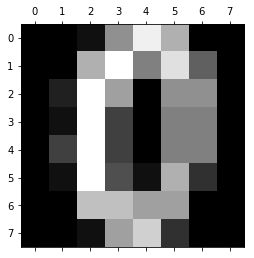

In [16]:
sns.reset_orig();

plt.gray()
plt.matshow(digits.images[10])
plt.show();

#### Write your code below

In [17]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        #print('searching: %s'%nb_path)
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        #print('searching: %s' % nb_path)
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        #print('Found %d cells'%len(nb.cells))
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]


#  register the NotebookFinder with sys.meta_path
print('running importer')
sys.meta_path.append(NotebookFinder())

running importer


In [18]:
# Import all relevant functions
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from utils import plot_decision_boundary, multi_class_signum, get_accuracy, get_prediction
from utils import plot_2D_input_datapoints, generate_gifs, normalize, signum

import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns; sns.set();
import pandas as pd
import math
import gif
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Perceptron training algorithm
def train(X_train, Y_train,weights, learning_rate=1, total_epochs=100):

  """Training method for Perceptron.
  
  Parameters
  -----------

  X_train: ndarray (num_examples(rows) vs num_features(columns))
    Input dataset which perceptron will use to learn optimal weights
  
  Y_train: ndarray (num_examples(rows) vs class_labels(columns))
    Class labels for input data

  weights: ndarray (num_features vs n_output)
    Weights used to train the network and predict on test set

  learning_rate: int
    Learning rate use to learn and update weights
  
  total_epochs: int
    Max number of epochs to train the perceptron model
  """

  n_samples, _ = np.shape(X_train)
   
  history_weights = []
  epoch = 1

  # Number of missclassified points we would like to see in the train set.
  # While training, its value will change every epoch. If m==0, our training 
  # error will be zero.
  m = 1

  # If the most recent weights gave 0 misclassifications, break the loop.
  # Else continue until total_epochs is completed.
  while m != 0 and epoch <= total_epochs:
    m = 0

    # Compute weighted inputs and predict class labels on training set.
    weights_transpose_x = np.dot(X_train, weights)
    weights_transpose_x = signum(weights_transpose_x)
    y_train_out = np.multiply(Y_train, weights_transpose_x)
    epoch += 1
    
    #print("computed weights", weights_transpose_x.shape , y_train_out.shape)
    
    # Collecting misclassified indexes and count them
    y_miscls_idxs = np.argwhere(y_train_out <= 0)[:, 0]
    y_miscls_idxs = np.unique(y_miscls_idxs)
    m = len(y_miscls_idxs)

    # Calculate gradients and update weights
    dweights = np.dot((X_train[y_miscls_idxs]).T, Y_train[y_miscls_idxs])
    
    #print("gradients step ", dweights.shape , weights.shape)
    #weights = weights.reshape((-1,)) 
    #print("gradients step ", dweights.shape , weights.shape)
    weights += (learning_rate/n_samples) * dweights
    weights = np.round(weights, decimals=4)

    # Append weights to visualize decision boundary later
    history_weights.append(weights)

  if m == 0 and epoch <= total_epochs:
    print("Training has stabilized with all points classified: ", epoch)
  else:
    print(f'Training completed at {epoch-1} epochs. {m} misclassified points remain.')

  return history_weights[-1], m 

# Run each 
weights = np.zeros((X_train.shape[1],Y_train.shape[1])) 
for i in range(Y_train.shape[1]):
    w,err = train(X_train, Y_train[:,i],weights[:,i], learning_rate=0.05, total_epochs=10000)   
    weights[:,i] = w                   


Training has stabilized with all points classified:  216
Training completed at 10000 epochs. 15 misclassified points remain.
Training has stabilized with all points classified:  102
Training has stabilized with all points classified:  1377
Training has stabilized with all points classified:  235
Training has stabilized with all points classified:  416
Training has stabilized with all points classified:  330
Training has stabilized with all points classified:  312
Training completed at 10000 epochs. 57 misclassified points remain.
Training completed at 10000 epochs. 8 misclassified points remain.


In [27]:
val_acc , val_pred = get_prediction(X_val,Y_val,weights, get_acc=True, model_type='perceptron', predict='no')
test_acc , test_pred = get_prediction(X_test,Y_test,weights, get_acc=True, model_type='perceptron', predict='no')

result = f"validation performance = {val_acc} vs test performance = {test_acc}"
print(result )

validation = 94.44444444444444 vs test performance = 95.83333333333334 


By increasing the number of epoches the miscalassification rate drop significantly